In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit


In [3]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column

data = pd.read_csv('2_categories_data.csv')
data.dropna(subset=['Label'], inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      627 non-null    object
 1   NDVI    627 non-null    object
 2   NBR     627 non-null    object
 3   Label   627 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 19.7+ KB


In [4]:

data['NBR'] = data['NBR'].apply(lambda x: pd.eval(x, local_dict={'nan': np.nan}))
data['NDVI'] = data['NDVI'].apply(lambda x: pd.eval(x, local_dict={'nan': np.nan}))
data.head()


,ID,NDVI,NBR,Label
0,20230813_100,"[0.7755693773142729, 0.8109320515721594, 0.851...","[0.003078832689977299, 0.049812837737360276, 0...",1
1,20230813_101,"[0.34495916148451133, 0.24291931815932866, 0.2...","[0.05116118296949416, -0.026290510714717576, 0...",1
2,20230813_102,"[0.8418304439153839, 0.798698150698662, 0.8062...","[0.058663947405941635, 0.04357172884127514, 0....",1
3,20230813_103,"[0.5716647915500211, 0.5872206605870187, 0.589...","[0.019482128930850738, 0.009917857640267346, 0...",1
4,20230813_104,"[-0.2217794764351386, -0.22595804483580587, -0...","[0.006908720294918405, 0.00880010401111331, -0...",0


In [5]:
# Combine NBR and NDVI data into a single feature array
# Flatten each sublist and concatenate NBR and NDVI for each row
X = np.array([np.ravel(nbr + ndvi) for nbr, ndvi in zip(data['NBR'], data['NDVI'])])
X = np.nan_to_num(X)

# Labels
y = data['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Fine tune gamma and C range for RBF kernel
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of 0.67


In [7]:
# Classifier used: Radial Basis Function (RBF)
# it can combine multiple polynomial kernels multiple times of different degrees to
# project the non-linearly separable data into higher dimensional space

# gamma: https://www.ibm.com/docs/sr/spss-modeler/18.0.0?topic=node-svm-expert-options
# C: https://vitalflux.com/svm-rbf-kernel-parameters-code-sample/

model = svm.SVC(kernel='rbf', gamma=0.01, C=1.0).fit(X_train, y_train)


In [8]:
# Calculate model efficiency

y_pred = model.predict(X_test)


In [9]:
# Calculate the accuracy and f1 scores for SVM with RBF kernel

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
average_precision = average_precision_score(y_test, y_pred.reshape(-1, 1), average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Average Precision: {average_precision:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.6772
Precision: 0.6749
Recall: 0.6703
Mean Average Precision: 0.6515

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.59      0.63        86
           1       0.69      0.75      0.72       103

    accuracy                           0.68       189
   macro avg       0.67      0.67      0.67       189
weighted avg       0.68      0.68      0.68       189


Confusion Matrix:
[[51 35]
 [26 77]]


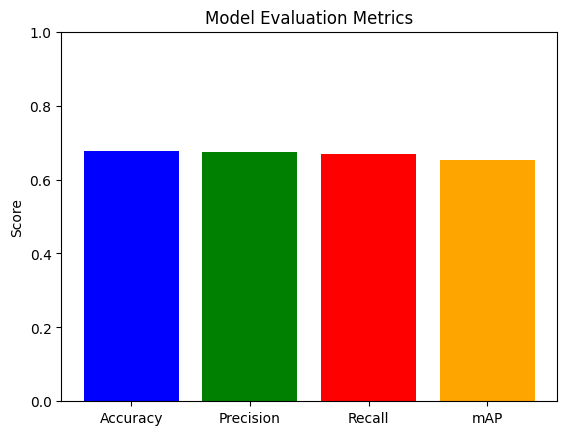

In [10]:
# Visualize the model evaluation metrics

metrics = ['Accuracy', 'Precision', 'Recall', 'mAP']
values = [accuracy, precision, recall, average_precision]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # to set y-axis limits from 0 to 1
plt.show()
